In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('animation', html='jshtml')

%matplotlib inline

# constants
r = .2
tau_E = 1.
tau_I = 2.

P = .2
Q = .5

w_ee = 10
w_ei = 12
w_ie = 9
w_ii = 3
k = 5

import numpy as np 
def sig(x):
    return 1/(1 + np.exp(-x))

def tanh(x):
    return 2*sig(2*x) - 1

def dedt(t, E, I, P):
    # de = (-E + (1 - r*E)*sig(w_ee*E - w_ei*I + P)) / tau_E
    de = (-E + sig(k*E + k*P)) / tau_E
    return de

def didt(t, E, I, Q):
    di = (-I + (1 - r*I)*tanh(w_ie*E - w_ii*I + Q)) / tau_I
    return np.array([di])

T = 10
dt = .01
t = np.arange(0, T + dt, dt)
E = np.zeros(len(t))
I = np.zeros(len(t))

for i in range(len(t) - 1):
    E[i + 1] = E[i] + dt * dedt(t[i], E[i], I[i], P) + np.random.normal(0, 0.5) 
    # I[i + 1] = I[i] + dt * didt(t[i], E[i], I[i], Q) + np.random.normal(0, 0.5) 

plt.plot(E, label='Excitatory')
# plt.plot(I, label='Inhibitory')
plt.legend()

np.save('E_synthetic_k5_Pdot2_noisy.npy', E)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import norm

N    = 200
X    = np.linspace(-4, 4, N)
Y    = np.linspace(-4, 4, N)
X, Y = np.meshgrid(X, Y)
pos  = np.dstack((X, Y))


def gauss2d(mean_a, mean_b, cov_aa, cov_bb):
    rv = multivariate_normal([mean_a, mean_b], [[cov_aa, 0.8], [0.8, cov_bb]])
    Z = rv.pdf(pos)
    plt.contour(X, Y, Z)
    plt.show()

def gauss1d(mean, std):
    X = np.linspace(-4, 4, N)
    z = norm.pdf(X, mean, std)
    plt.plot(X, z)
    plt.show()
    
# interact(gauss2d, mean_a = widgets.FloatSlider(value=0, min=0.1, max=5, step=0.1),
#     mean_b = widgets.FloatSlider(value=0, min=0.1, max=5, step=0.1),
#     cov_aa = widgets.FloatSlider(value=1, min=0.1, max=5, step=0.1),
#     cov_bb = widgets.FloatSlider(value=2, min=0.1, max=5, step=0.1))

interact(gauss1d, mean = widgets.FloatSlider(value = 0, min = 0, max = 5, step=0.1), std = widgets.FloatSlider(value = 0, min = .1, max = 3, step = 0.1))

In [ ]:
Et_slider = widgets.FloatSlider(value = 0, min = -5, max = 5, step=0.1)

def gauss1d_neuronal(Et, std):
    X = np.linspace(-4, 4, N)
    mean = Et + dt*dedt(0, Et, I=0, P=.2)
    print(Et, mean)
    z = norm.pdf(X, mean, std)
    plt.plot(X, z)
    plt.show()

def gauss2d_neuronal(mean_a, mean_b, cov_aa, cov_bb):
    rv = multivariate_normal([mean_a, mean_b], [[cov_aa, 0.8], [0.8, cov_bb]])
    Z = rv.pdf(pos)
    plt.contour(X, Y, Z)
    plt.show()

interact(gauss1d_neuronal, Et = Et_slider, std = 0.5)

In [ ]:
# import numpy as np
import matplotlib.pyplot as plt

P = .2
sigma_n = 0.05

def sig(x):
    return 1/(1 + np.exp(-x))

def ddedt(E):
    s =  sig(k*E + k*P)
    dde = (-1 + k * s * (1 - s)) / tau_E
    return dde

def j_func(E):
    return 1 + ddedt(E)

def Etp(E):
    return E + dedt(0, E, 0, P)

def linearised(x0):
    J = j_func(X)
    return Etp(x0) + J*(X - x0)

def gauss_approx(x0):
    J_x0 = j_func(x0)
    sigman_inv = (1/sigma_n)
    eta = J_x0.T * (z(x0) - Etp(x0) + J_x0*x0)
    lam = J_x0.T * sigman_inv * J_x0

    return eta, lam

X = np.linspace(-1, 1, 500)

def z(X):
    X = np.asarray(X)
    return Etp(X) + np.random.normal(0, 0.05, size=X.shape)

def linearised_with_slider(x0):
    plt.plot(X, z(X))
    plt.plot(X, linearised(x0))
    plt.axvline(x = x0, color = 'b', label = 'axvline - full height')
    plt.show()

X = np.linspace(-1, 1, 500)
x0 = 0.5

# interact(linearised_with_slider, x0 = widgets.FloatSlider(value = 0, min = -1, max = 1, step=0.1))

def gauss1d(mean, std):
    z = norm.pdf(np.linalg.norm(-5, 5, 500), mean, std)
    plt.plot(np.linalg.norm(-5, 5, 500), z)
    plt.show()

def inf_to_moments(eta, lam):
    return (eta/lam, 1/lam)

gauss1d(*inf_to_moments(*gauss_approx(0.5)))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import norm
import torch

tau_E = 1.
P = .2
k = 5

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))
    
def _dedt(E):
    return (-E + sigmoid(k*E + k*P)) / tau_E

def meas_fn(Et):
    return Et + _dedt(Et)

def jac_fn(Et):
    meas_fn(Et).backward()
    return Et.grad

x0 = 0.2
x_pos = torch.as_tensor(x0).requires_grad_(True)
MEAS = meas_fn(x_pos)
meas_lam = torch.tensor([1/0.1])
# pred_meas = 0.8

pred_meas = torch.linspace(0.5, 1.5, 10)

diff = MEAS - pred_meas
    
print(torch.exp(-0.5 * diff * meas_lam * diff.T).detach().numpy())

jac = jac_fn(x_pos)

diff = MEAS - pred_meas
lam = jac.T * meas_lam * jac
eta = jac.T * meas_lam * (diff + jac * x_pos)

print(torch.exp(-0.5 * MEAS * lam * MEAS - eta * MEAS))

/var/folders/5g/hyv5_r417lgcw4q4fw84b9nw0000gn/T/ipykernel_44342/52257136.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Et, Etp = torch.tensor(Et, requires_grad=True), torch.tensor(Etp, requires_grad=True)


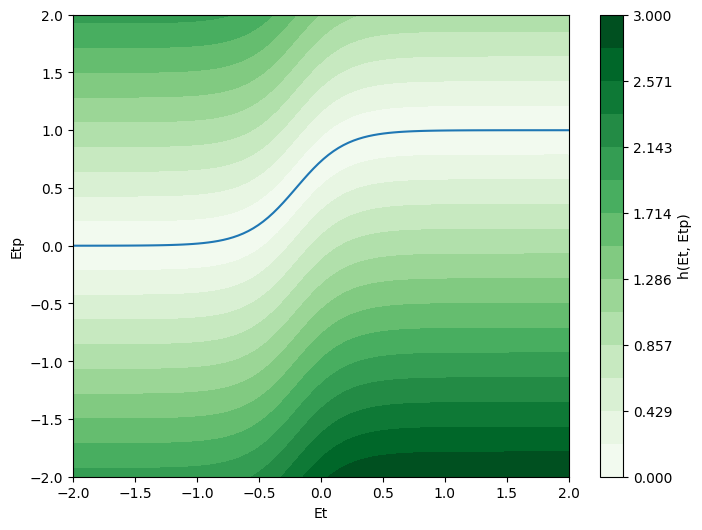

(tensor([-1.3576,  3.8790], grad_fn=<MulBackward0>), tensor(5.9186))

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import norm
import torch

k = 5
P = .2
tau_E = 1

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))
    
def _dedt(E):
    return (-E + sigmoid(k*E + k*P)) / tau_E

def meas_fn(Et, Etp):
    Etp, Et = torch.as_tensor(Etp), torch.as_tensor(Et)
    return torch.abs(Etp - (Et + _dedt(Et)))

Et = torch.tensor(0.2, requires_grad=True)
Etp = torch.tensor(0.8, requires_grad=True)
# Et = 0.2

sigma_n = torch.tensor([[1/0.3, 0.], [0, 1/0.2]])

Et, Etp = torch.tensor(Et, requires_grad=True), torch.tensor(Etp, requires_grad=True)
h = meas_fn(Et, Etp)
h.backward()

J = torch.tensor((Et.grad, Etp.grad))
eta = J.T @ sigma_n * (J @ torch.tensor([Et, Etp]) - h) 
lam = J.T @ sigma_n @ J

Et_values = np.linspace(-2, 2, 100)
Etp_values = np.linspace(-2, 2, 100)
Et_grid, Etp_grid = np.meshgrid(Et_values, Etp_values)

# Evaluate the function over the grid (vectorized)
Et_tensor = torch.from_numpy(Et_grid)
Etp_tensor = torch.from_numpy(Etp_grid)
meas_values = meas_fn(Et_tensor, Etp_tensor).numpy()

# Plot the contour plot
fig, ax = plt.subplots(figsize=(8, 6))
contour_levels = np.linspace(np.min(meas_values), np.max(meas_values), 15)
cp = ax.contourf(Et_grid, Etp_grid, meas_values, levels=contour_levels, cmap='Greens')
ax.plot(Et_values, (torch.tensor(Et_values) + _dedt(torch.tensor(Et_values))).numpy())
ax.set_xlabel('Et')
ax.set_ylabel('Etp')
cbar = fig.colorbar(cp)
cbar.set_label('h(Et, Etp)')
plt.show()

def inf_to_moments(eta, lam):
    return (eta/lam, 1/lam)

eta, lam